In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import netwulf as nw
from netwulf import visualize
import pandas as pd
from statistics import mean
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from sklearn.model_selection import train_test_split
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from math import log
import os
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# GraphSAGE and GAT Preprocessing 
# Step 1 Loading Graph Data (Making it Homogenous)
# Treating drug and gene name as an feature dimensions and creating 2-D one-hot vector 

edges = pd.read_csv('ChG-Miner_miner-chem-gene.tsv', sep = '\t')
drugs = pd.DataFrame(index=pd.unique(edges["#Drug"])).assign(drug=1, gene=0)
genes = pd.DataFrame(index=pd.unique(edges["Gene"])).assign(drug=0, gene=1)

nodes = pd.concat([drugs, genes])
Minergraphv = sg.StellarGraph(
    nodes, 
    edges,
    source_column="#Drug", 
    target_column="Gene",
)
# Need to write Steller Graph constructor to create a graph with one node type
print(nodes.sample(3))
G=Minergraphv.node_degrees()
#print('Average Degree : ' + str(mean(G[k] for k in G)))
#print(Minergraphv.info())

         drug  gene
DB05127     1     0
P49190      0     1
DB04716     1     0
Average Degree : 4.123382813563938
StellarGraph: Undirected multigraph
 Nodes: 7343, Edges: 15139

 Node types:
  default: [7343]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [15139]
        Weights: all 1 (default)


In [3]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(Minergraphv)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

Removed 1000 edges
Sampled 1000 negative examples
** Sampled 1513 positive and 1513 negative edges. **


In [4]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

Removed 1000 edges
Sampled 1000 negative examples
** Sampled 1362 positive and 1362 negative edges. **


In [5]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 7343, Edges: 12264

 Node types:
  default: [7343]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [12264]
        Weights: all 1 (default)


In [6]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 7343, Edges: 13626

 Node types:
  default: [7343]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [13626]
        Weights: all 1 (default)


In [7]:
batch_size = 20
epochs = 20

In [8]:
num_samples = [20, 10]

In [9]:
#Training with Shuffle 2 layers
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [10]:
# Test without shuffle
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [11]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [12]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

In [13]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [14]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [15]:
#Evaluate the initial (untrained) model on the train and test set

init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
137/137 [==============================] - 9s 63ms/step - loss: 4.6993 - acc: 0.2232
  ...
    to  
  ['...']
152/152 [==============================] - 9s 60ms/step - loss: 4.9185 - acc: 0.2115

Train Set Metrics of the initial (untrained) model:
	loss: 4.6993
	acc: 0.2232

Test Set Metrics of the initial (untrained) model:
	loss: 4.9185
	acc: 0.2115


In [16]:
#Training the model
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 137 steps, validate for 152 steps
Epoch 1/20
137/137 - 18s - loss: 0.8870 - acc: 0.4662 - val_loss: 4.9296 - val_acc: 0.5000
Epoch 2/20
137/137 - 17s - loss: 0.7881 - acc: 0.5426 - val_loss: 5.1018 - val_acc: 0.5000
Epoch 3/20
137/137 - 16s - loss: 0.7667 - acc: 0.5587 - val_loss: 5.2838 - val_acc: 0.5000
Epoch 4/20
137/137 - 16s - loss: 0.7560 - acc: 0.5683 - val_loss: 5.2294 - val_acc: 0.5000
Epoch 5/20
137/137 - 16s - loss: 0.7379 - acc: 0.5639 - val_loss: 5.3598 - val_acc: 0.5000
Epoch 6/20
137/137 - 17s - loss: 0.7449 - acc: 0.5595 - val_loss: 5.5336 - val_acc: 0.5000
Epoch 7/20
137/137 - 16s - loss: 0.7335 - acc: 0.5742 - val_loss: 5.3881 - val_acc: 0.5000
Epoch 8/20
137/137 - 15s - loss: 0.7284 - acc: 0.5661 - val_loss: 5.3773 - val_acc: 0.5000
Epoch 9/20
137/137 - 19s - loss: 0.7430 - acc: 0.5518 - val_loss: 5.5021 - val_acc: 0.5000
Epoch 10/20
137/137 - 20s - loss: 0.7214 - acc: 0.5679 - val_loss: 5.3575 - val_acc: 0.

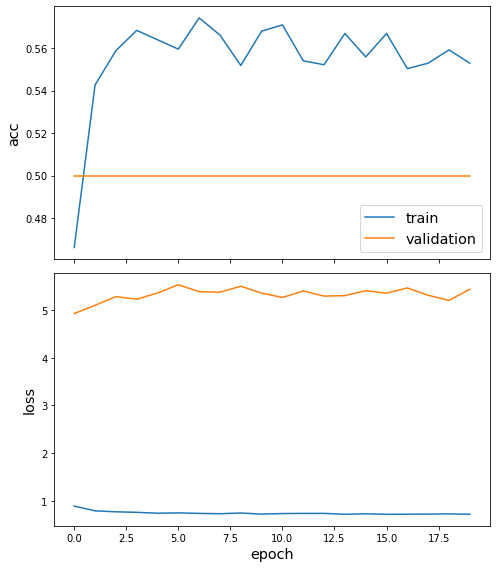

In [17]:
sg.utils.plot_history(history)

In [18]:
#Evaluate the trained model on test citation links:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
137/137 [==============================] - 6s 46ms/step - loss: 5.2632 - acc: 0.5000
  ...
    to  
  ['...']
152/152 [==============================] - 8s 50ms/step - loss: 5.4391 - acc: 0.5000

Train Set Metrics of the trained model:
	loss: 5.2632
	acc: 0.5000

Test Set Metrics of the trained model:
	loss: 5.4391
	acc: 0.5000
